In [40]:
!pip install pycaret

In [41]:
import pandas as pd

# Loading datasets with '\N' recognized as NaN
races_df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/races.csv', na_values='\\N')
results_df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv', na_values='\\N')
drivers_df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv', na_values='\\N')
constructors_df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv', na_values='\\N')

# Merging datasets to create 'merged_df'
merged_df = results_df.merge(races_df, on='raceId').merge(drivers_df, on='driverId').merge(constructors_df, on='constructorId')

# Removing 'url' and 'url_y' columns from the merged DataFrame
merged_df.drop(['url', 'url_y'], axis=1, inplace=True)

# Filtering to include data from the year 2000 onwards
df = merged_df[merged_df['year'] >= 2000]

#Step 3: Preprocessing
# 1- Feature Engineering
# Calculate the average finish position for each driver
driver_avg_finish = df.groupby('driverId')['positionOrder'].transform('mean').rename('driver_avg_finish')
df = df.assign(driver_avg_finish=driver_avg_finish)

# Define a win as having a 'positionOrder' of 1 and create the 'winner' column
df['winner'] = (df['positionOrder'] == 1).astype(int)

# Calculate win rate for each constructor using the 'winner' column
constructor_win_rate = df.groupby('constructorId')['winner'].transform('mean').rename('constructor_win_rate')
df = df.assign(constructor_win_rate=constructor_win_rate)

# 'grid' represents the qualifying position
qualifying_avg_position = df.groupby('driverId')['grid'].transform('mean').rename('qualifying_avg_position')
df = df.assign(qualifying_avg_position=qualifying_avg_position)

# Assuming 'dob' is the date of birth of the driver and 'date' is the race date
df['dob'] = pd.to_datetime(df['dob'])
df['date'] = pd.to_datetime(df['date'])

# Calculate driver's age at the time of the race
df['driver_age'] = df['date'].dt.year - df['dob'].dt.year

# Experience level: calculated as the number of years since the first race
# First, find the driver's first race year
first_race_year = df.groupby('driverId')['date'].min().dt.year.rename('first_race_year')

# Merge it back to the main dataframe
df = df.merge(first_race_year, on='driverId')

# Calculate experience level
df['experience_level'] = df['date'].dt.year - df['first_race_year']

# Drop the 'positionOrder' column since it's used to create the target
df.drop('positionOrder', axis=1, inplace=True)

# Drop columns with null values more than 90% of the data
columns_to_drop = ['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
df.drop(columns=columns_to_drop, inplace=True, axis=1)

# Extracting more general features from the 'date' column
df['race_month'] = df['date'].dt.month
df.drop('date', axis=1, inplace=True)

# Set option to display all columns
pd.set_option('display.max_columns', None)

df.head()

,resultId,raceId,driverId,constructorId,number_x,grid,position,positionText,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,name_x,time_y,url_x,driverRef,number_y,code,forename,surname,dob,nationality_x,constructorRef,name_y,nationality_y,driver_avg_finish,winner,constructor_win_rate,qualifying_avg_position,driver_age,first_race_year,experience_level,race_month
0,1,18,1,1,22.0,1,1.0,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1,2008,1,1,Australian Grand Prix,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,4.770186,1,0.067416,3.934783,23,2007,1,3
1,27,19,1,1,22.0,9,5.0,5,4.0,56,+46.548,5525103.0,53.0,3.0,1:35.462,209.033,1,2008,2,2,Malaysian Grand Prix,07:00:00,http://en.wikipedia.org/wiki/2008_Malaysian_Gr...,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,4.770186,0,0.067416,3.934783,23,2007,1,3
2,57,20,1,1,22.0,3,13.0,13,0.0,56,NaN,NaN,25.0,19.0,1:35.520,203.969,11,2008,3,3,Bahrain Grand Prix,11:30:00,http://en.wikipedia.org/wiki/2008_Bahrain_Gran...,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,4.770186,0,0.067416,3.934783,23,2007,1,4
3,69,21,1,1,22.0,5,3.0,3,6.0,66,+4.187,5903238.0,20.0,3.0,1:22.017,204.323,1,2008,4,4,Spanish Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2008_Spanish_Gran...,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,4.770186,0,0.067416,3.934783,23,2007,1,4
4,90,22,1,1,22.0,3,2.0,2,8.0,58,+3.779,5213230.0,31.0,2.0,1:26.529,222.085,1,2008,5,5,Turkish Grand Prix,12:00:00,http://en.wikipedia.org/wiki/2008_Turkish_Gran...,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,4.770186,0,0.067416,3.934783,23,2007,1,5


In [42]:
import pandas as pd

# To ensure all categorical data is of type string
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype(str)

# 2- Handling missing values
# Impute numeric columns with the median
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Impute categorical columns with the mode
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    mode_value = df[col].mode()[0]  # mode() returns a Series, select the first element
    df[col] = df[col].fillna(mode_value)

# Check for any remaining missing values
total_missing_values = df.isnull().sum().sum()
print(f"Total missing values in the DataFrame after imputation: {total_missing_values}")

# Check missing values per column if total isn't zero
if total_missing_values > 0:
    missing_values_per_column = df.isnull().sum()
    print("Missing values per column after imputation:\n", missing_values_per_column)

Total missing values in the DataFrame after imputation: 0


In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample

# Convert datetime to a numeric feature
if 'dob' in df.columns:
    df['dob'] = pd.to_datetime(df['dob']).astype('int64') // 10**9  # Convert to timestamp

# 3- Encoding categorical variables
# Encode categorical variables and ensure all are numeric
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Ensure all boolean columns are converted to int
boolean_cols = df.select_dtypes(include=['bool']).columns
df[boolean_cols] = df[boolean_cols].astype(int)

# Separate target and features
X = df.drop('winner', axis=1)
y = df['winner'].astype(int)  # Ensure the target is also numeric

# 4- Handle class imbalance
# Handle class imbalance by oversampling minority class
X_resampled, y_resampled = resample(X[y==1], y[y==1],
                                    replace=True, # sample with replacement
                                    n_samples=X[y==0].shape[0], # match number in majority class
                                    random_state=42) # reproducible results
X_balanced = pd.concat([X[y==0], X_resampled])
y_balanced = pd.concat([y[y==0], y_resampled])

# Scale numeric columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Feature Selection using Random Forest to determine feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_balanced)

# Selecting features based on importance
selector = SelectFromModel(rf, threshold='median', prefit=True)
X_selected = selector.transform(X_scaled)

# 5- Dimensionality reduction
# Applying PCA
pca = PCA(n_components=5) 
X_pca = pca.fit_transform(X_selected)

# 6- Random Sampling
sampled_indices = pd.Series(range(len(X_pca))).sample(frac=0.3, random_state=42).index
X_train, X_test, y_train, y_test = train_test_split(X_pca[sampled_indices], y_balanced.iloc[sampled_indices], test_size=0.3, random_state=42)

# Output shapes to confirm sizes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3761, 5)
Shape of X_test: (1612, 5)
Shape of y_train: (3761,)
Shape of y_test: (1612,)


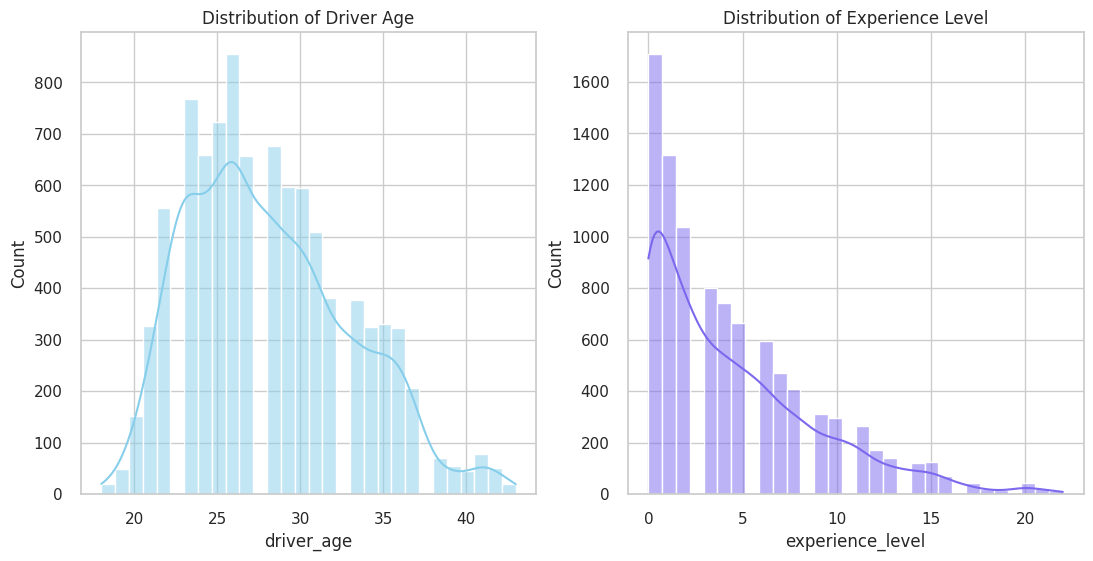

In [46]:
#Step 4: EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Distribution of Numerical Features
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['driver_age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Driver Age')

plt.subplot(1, 3, 2)
sns.histplot(df['experience_level'], kde=True, bins=30, color='mediumslateblue')
plt.title('Distribution of Experience Level');

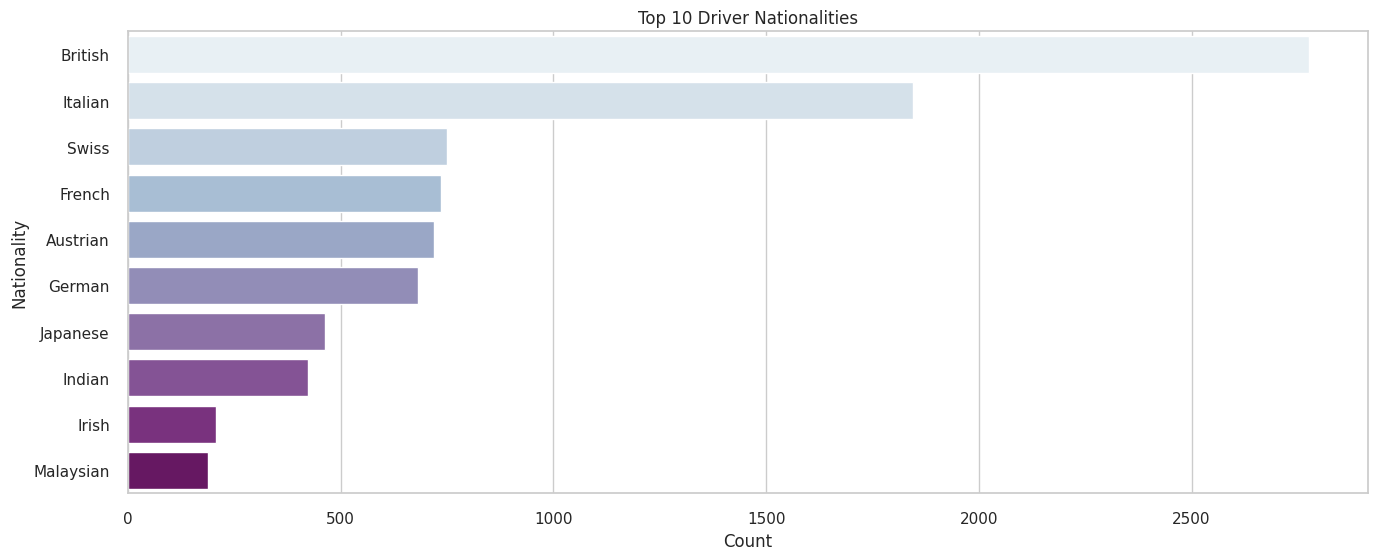

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out columns that are one-hot encoded versions of 'nationality_y'
nationality_columns = [col for col in df.columns if col.startswith('nationality_y_')]

# Sum up all the one-hot encoded nationality columns to get a total count for each
nationality_counts = df[nationality_columns].sum().sort_values(ascending=False).head(10)

# Extract the nationality names from the column names by removing 'nationality_y_'
nationality_names = [name.split('_')[2] for name in nationality_counts.index]

# Create the plot
plt.figure(figsize=(16, 6))
sns.barplot(x=nationality_counts.values, y=nationality_names, palette='BuPu')
plt.title('Top 10 Driver Nationalities')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.show()


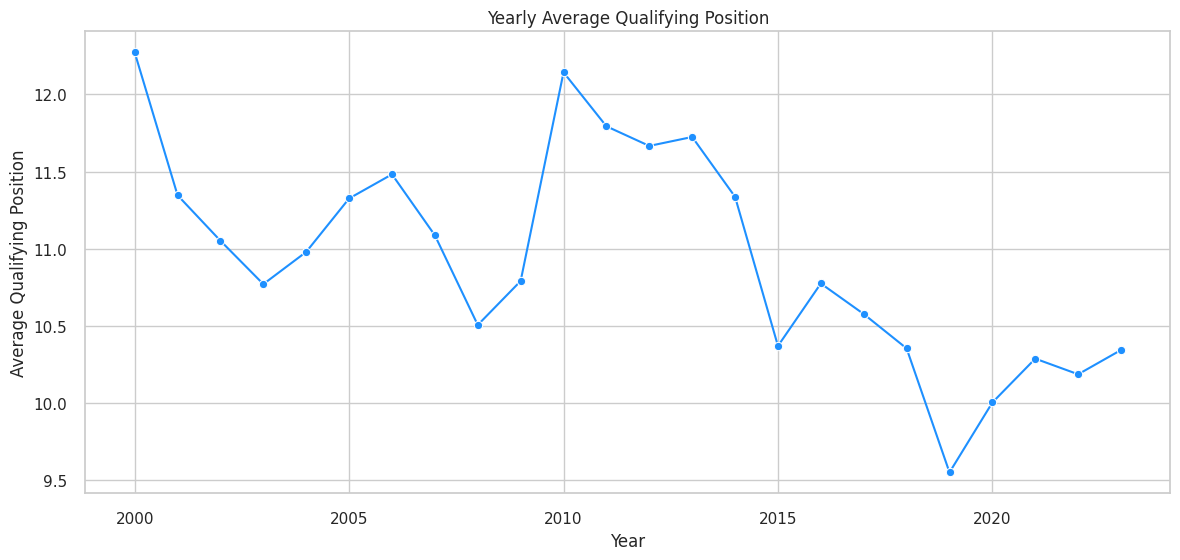

In [48]:
# Performance Trends
plt.figure(figsize=(14, 6))
yearly_performance = df.groupby('year')['qualifying_avg_position'].mean()
sns.lineplot(x=yearly_performance.index, y=yearly_performance.values, marker='o', color='dodgerblue')
plt.title('Yearly Average Qualifying Position')
plt.xlabel('Year')
plt.ylabel('Average Qualifying Position')
plt.show()

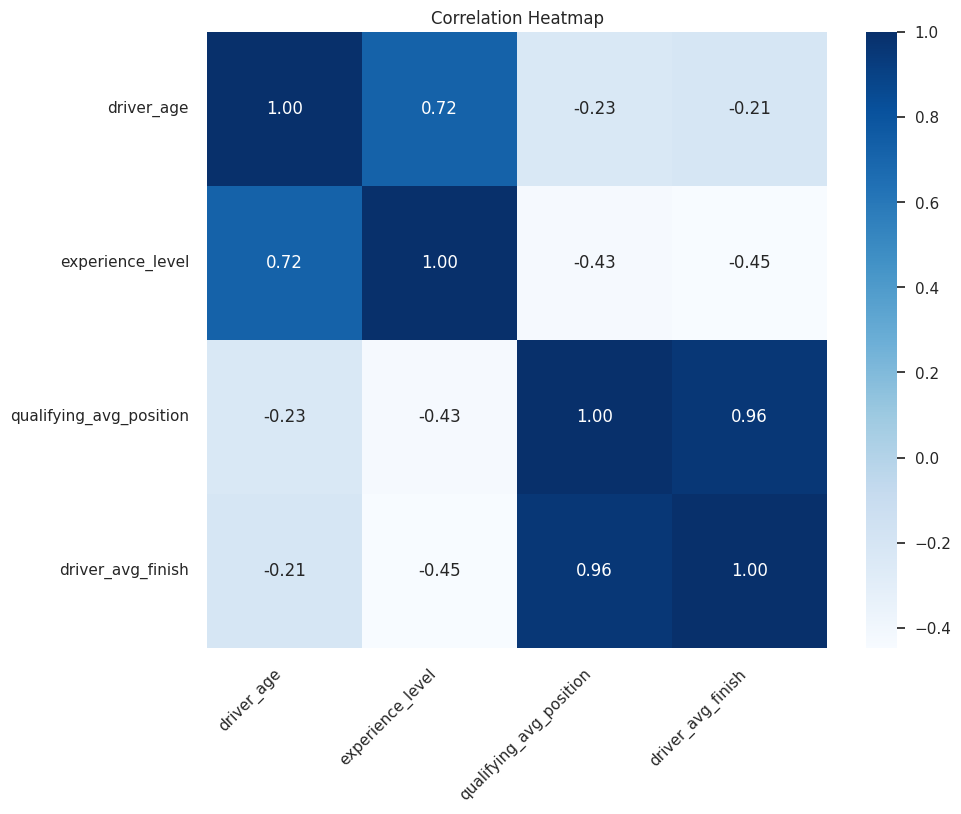

In [49]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df[['driver_age', 'experience_level', 'qualifying_avg_position', 'driver_avg_finish']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

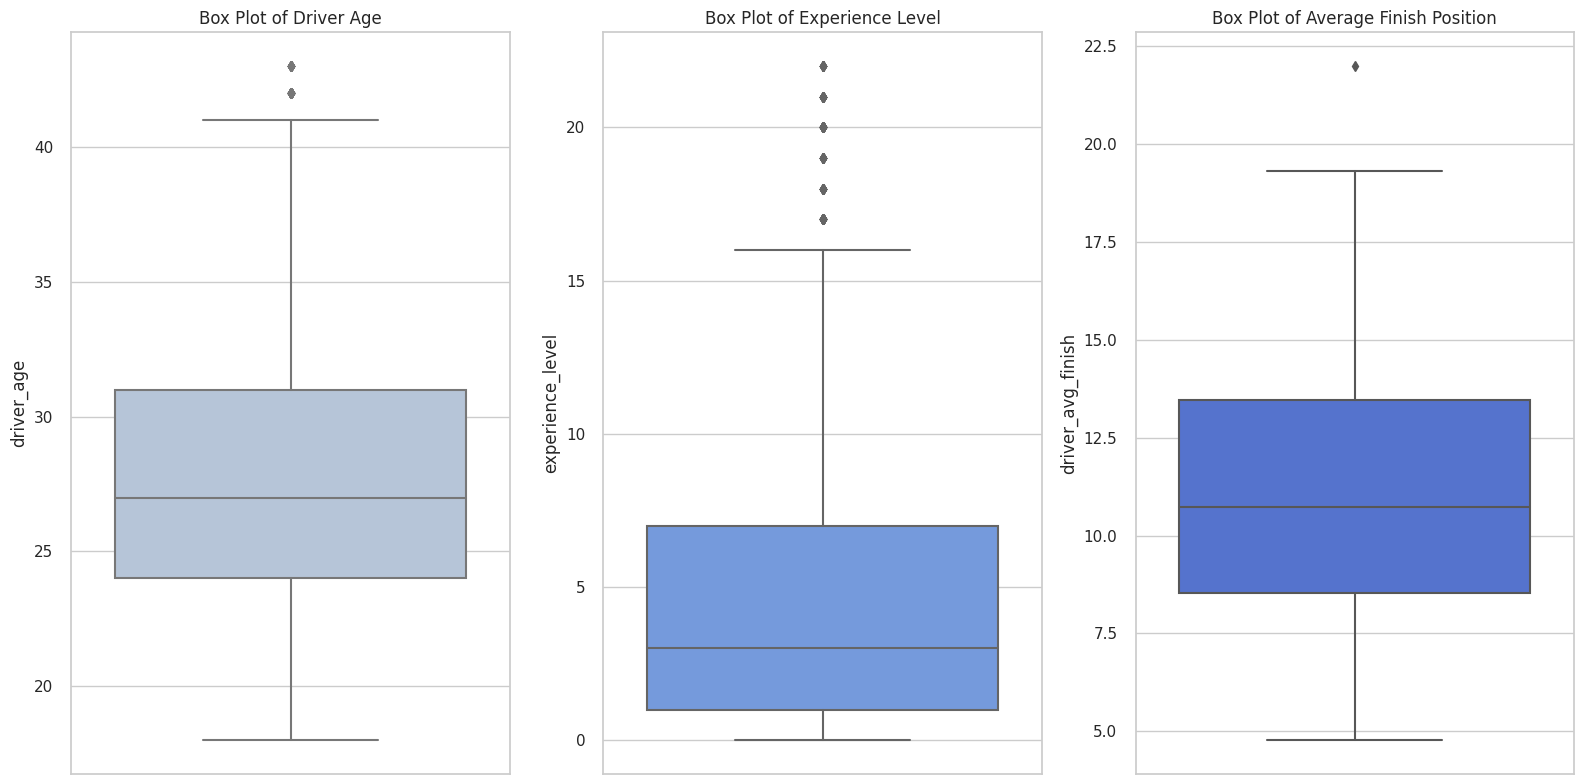

In [50]:
# Outlier Detection with Box Plots
plt.figure(figsize=(16, 8))

# Driver Age
plt.subplot(1, 3, 1)
sns.boxplot(y=df['driver_age'], color='lightsteelblue')
plt.title('Box Plot of Driver Age')

# Experience Level
plt.subplot(1, 3, 2)
sns.boxplot(y=df['experience_level'], color='cornflowerblue')
plt.title('Box Plot of Experience Level')

# Average Finish Position
plt.subplot(1, 3, 3)
sns.boxplot(y=df['driver_avg_finish'], color='royalblue')
plt.title('Box Plot of Average Finish Position')

plt.tight_layout()
plt.show()

In [51]:
# Step 5: Model Building
from pycaret.classification import setup, compare_models, tune_model, pull, evaluate_model
import pandas as pd

# Prepare the combined training set for PyCaret
train_df = pd.DataFrame(X_train, columns=[f'Feature_{i+1}' for i in range(X_train.shape[1])])
train_df['winner'] = y_train.reset_index(drop=True)

# Initialize PyCaret's setup
clf_setup = setup(data=train_df, target='winner', session_id=123, preprocess=False, normalize=True, 
                  remove_multicollinearity=True, multicollinearity_threshold=0.95, verbose=False)

# Compare models and select the top 3
best_models = compare_models(include=['dt', 'lr', 'rf'], n_select=3, verbose=False)

results_dict = {}

# Hyperparameter sets for tuning
hyperparameters = {
    'DecisionTreeClassifier': {'max_depth': [5, 10, 15]},
    'LogisticRegression': {'C': [0.01, 0.1, 1]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 150]}
}

# Evaluate and tune each model
for model in best_models:
    model_name = model.__class__.__name__

    # Step 6: Model Evaluation
    # Evaluate the original model
    evaluate_model(model)
    original_results = pull()
    results_dict[f"{model_name} Original"] = original_results

    # Tune for a single hyperparameter with three different values
    param_key = list(hyperparameters[model_name].keys())[0]  # Get the hyperparameter name
    for value in hyperparameters[model_name][param_key]:
        custom_grid = {param_key: [value]}
        tuned_model = tune_model(model, custom_grid=custom_grid, verbose=False)
        evaluate_model(tuned_model)
        tuned_results = pull()
        results_dict[f"{model_name} {param_key}={value}"] = tuned_results

# Print all results
for key, result in results_dict.items():
    print(f"Results for {key}:")
    print(result)
    print("\n")


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Results for RandomForestClassifier Original:
                       Model  Accuracy     AUC  Recall   Prec.      F1  \
rf  Random Forest Classifier    0.9738  0.9952  0.9939  0.9551  0.9741   
dt  Decision Tree Classifier    0.9582  0.9585  0.9816  0.9371  0.9588   
lr       Logistic Regression    0.8872  0.9490  0.9194  0.8618  0.8895   

     Kappa     MCC  TT (Sec)  
rf  0.9476  0.9485     0.308  
dt  0.9165  0.9176     0.634  
lr  0.7745  0.7765     0.016  


Results for RandomForestClassifier n_estimators=50:
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9735  0.9894  0.9924  0.9559  0.9738  0.9470  0.9477
1       0.9621  0.9893  0.9618  0.9618  0.9618  0.9242  0.9242
2       0.9848  0.9999  1.0000  0.9701  0.9848  0.9696  0.9700
3       0.9810  0.9983  1.0000  0.9630  0.9811  0.9620  0.9627
4       0.9810  0.9976  1.0000  0.9630  0.9811  0.9620  0.9627
5       0.9658  0.9814  1.0000  0.9353 